# Analysing temporally and spatially disjointed AOIs

Sometimes, we might be interested in AOIs that are spatially far apart from each other, eventually far enough that we cannot make one reference image that includes them all.

In this case, we can take one reference image for each AOI and analyse gaze data on and between these.

This guide will show you how to 

- load data from multiple reference image enrichments into one datafile
- visualize multiple reference images next to each other
- compute fixation metrics, comparable to AOI analysis within one reference image

We will use the example of our museum study, where each painting is one AOI.

## Loading data from multiple folders

Once you've created multiple reference image mapper enrichments and downloaded them, we recommend putting all relevant enrichments into one folder.

To download the files recursively, we will first define some helper functions.

In [1]:
import os
import numpy as np
import pandas as pd

# Define the folder with our data
path_to_folders = './reference_image_enrichments/'

def get_file_list(file_name, directory = path_to_folders):
    """
    returns a list of paths to all files of a given name in subfolders of the given directory
    """
    all_aoi_recordings = os.listdir(directory)
    return [f"{directory}{aoi}/{file_name}" for aoi in all_aoi_recordings]

# define a function that extracts the image name from the path
extract_name = lambda name: name.split('MAPPER_')[1].split('_walking')[0]

def load_csv_files(file_name):  
    """
    recursively loads csv files and concatenates them in a long data frame
    """
    file_list = get_file_list(file_name)
    data = pd.DataFrame()
    
    for file in file_list:
        
        df = pd.read_csv(file)
        df['AOI'] = extract_name(file)
        
        data = pd.concat([data,df], ignore_index = True)
        
    return data

## Load and display an array of reference images

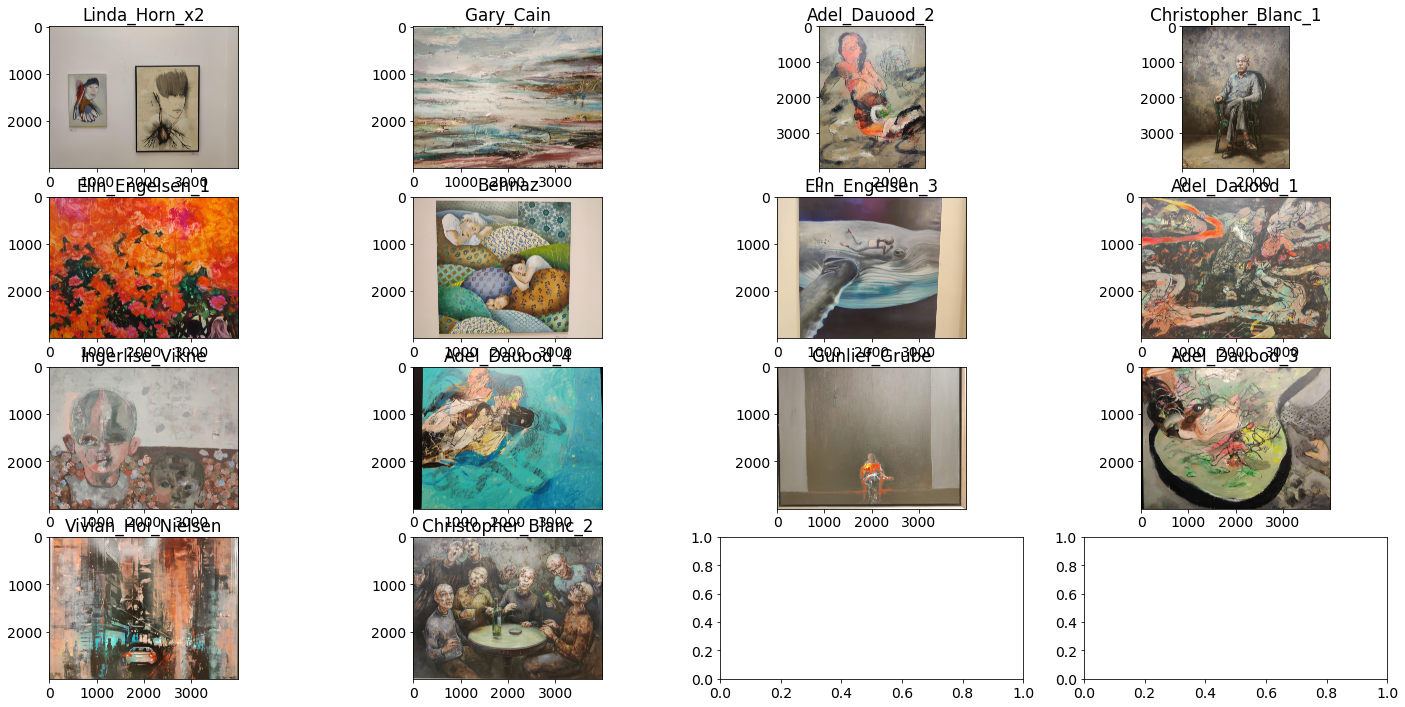

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
plt.rcParams.update({'font.size': 14})

# Load images
images = get_file_list('reference_image.jpeg')

# Initialize list of AOI names
aoi_names = []

# create a plot for the images
fig_reference, ax_reference = plt.subplots(int(np.ceil(len(images)/4)),4, figsize = (25, 25))

for ax, im in zip(ax_reference.flatten(), images):
    reference_image = Image.open(im)
    ax.imshow(np.asarray(reference_image))
    name = extract_name(im)
    aoi_names.append(name)
    ax.set_title(name)

Each reference image shows an individual image and can be thought of as one Area of Interest. We can use the name of the reference image mapper to identify the paintings and the fixations that belong to each of them.

## Loading fixation data

In [3]:
fixations = load_csv_files('fixations.csv')

# shorten the image names
# fixations['AOI'] = fixations['AOI'].replace({
#    'Adel_Dauood_2': 'AD 2',
#    'Adel_Dauood_3': 'AD 3',
#    'Adel_Dauood_4': 'AD 4',
#    'Christopher_Blanc_2': 'Blanc 2',
#    'Gary_Cain' : 'Cain',
#    'Gunlief_Grube': 'Grube',
#    'Ingerlise_Vikne': 'Vikne',
#    'Vivian_Hoi_Nielsen': 'Nielsen'
#    
#})

recordings = np.unique(fixations['recording id'])

## Filter the data for fixation on a reference image

The fixation data from the Reference Image Mapper will include fixations inside and outside the reference image. To select only fixations inside the reference image, we can filter them with the help of the column **'gaze detected on reference image'**.

In [4]:
print(f"The fixation data frame originally contained {len(fixations)} samples.")

# filter the data frames 
fixations_unfiltered = fixations.copy()
fixations = fixations[fixations['fixation detected in reference image']] 

print(f"After cleaning, the fixation data frame contained {len(fixations)} samples.")

fixations.head()

The fixation data frame originally contained 38020 samples.
After cleaning, the fixation data frame contained 1950 samples.


,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI
1,d93e69d3-4205-42fa-9b87-3fd06d49deb9,7952958b-c02a-4e3f-9f01-637f34cd1439,33,1636035260373732164,1636035261125733164,752,True,969.0,1338.0,Linda_Horn_x2
2,d93e69d3-4205-42fa-9b87-3fd06d49deb9,7952958b-c02a-4e3f-9f01-637f34cd1439,34,1636035261173759164,1636035261297761164,124,True,698.0,1387.0,Linda_Horn_x2
3,d93e69d3-4205-42fa-9b87-3fd06d49deb9,7952958b-c02a-4e3f-9f01-637f34cd1439,35,1636035261413763164,1636035261501736164,87,True,549.0,1774.0,Linda_Horn_x2
4,d93e69d3-4205-42fa-9b87-3fd06d49deb9,7952958b-c02a-4e3f-9f01-637f34cd1439,36,1636035261541734164,1636035261681740164,140,True,566.0,2074.0,Linda_Horn_x2
5,d93e69d3-4205-42fa-9b87-3fd06d49deb9,7952958b-c02a-4e3f-9f01-637f34cd1439,37,1636035261781735164,1636035262101772164,320,True,939.0,1306.0,Linda_Horn_x2


## Align the fixation timestamps to the sections start.

Since our participants all started their walk in the museum at different times, we will align the timestamp of each fixation to the start of each section.

In [5]:
sections = load_csv_files('sections.csv')

def align_timestamps(df, sections, time_columns, recordings = recordings):
    for recording in recordings:
        recording_idx = df[df['recording id'] == recording].index
        section_start_time = min(sections[sections['recording id'] == recording]['section start time [ns]'].values)
        for column in time_columns:
            aligned_name = f'aligned {column}'
            df.loc[recording_idx, aligned_name] = (df.loc[recording_idx, column] - section_start_time)

align_timestamps(fixations, sections, ['start timestamp [ns]', 'end timestamp [ns]'])

## Visual journey
Having every single AOI in an individual reference image poses a challenge for visualizing the fixations across them. This is mainly because every AOI now lives in their own coordinate system, and we have lost the mapping between them.

This means, we cannot show a classical scanpath that connects different fiaxtions between the AOIs. Instead, we will show how the eyes travel from image to image, using an approach we call **visual journey**. 

In the visual journey, we visualize in which reference images were visited in time, rather than in space. 

In [6]:
# re-label the recording id for clearer naming
id_name_dict = {}
for rec_id, rec_name in zip (sections['recording id'], sections['recording name']):
    id_name_dict[rec_id] = rec_name
    
fixations['recording name'] = fixations['recording id'].replace(id_name_dict)

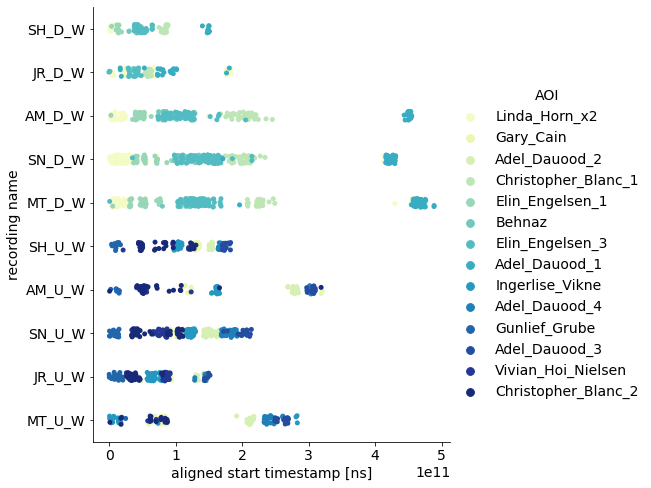

In [7]:
import seaborn as sns

sns.catplot(
    data=fixations,
    x="aligned start timestamp [ns]",
    y="recording name",
    hue="AOI",
    aspect=1,
    linewidth=0,
    s=5,
    palette = 'YlGnBu',
    height = 7
);

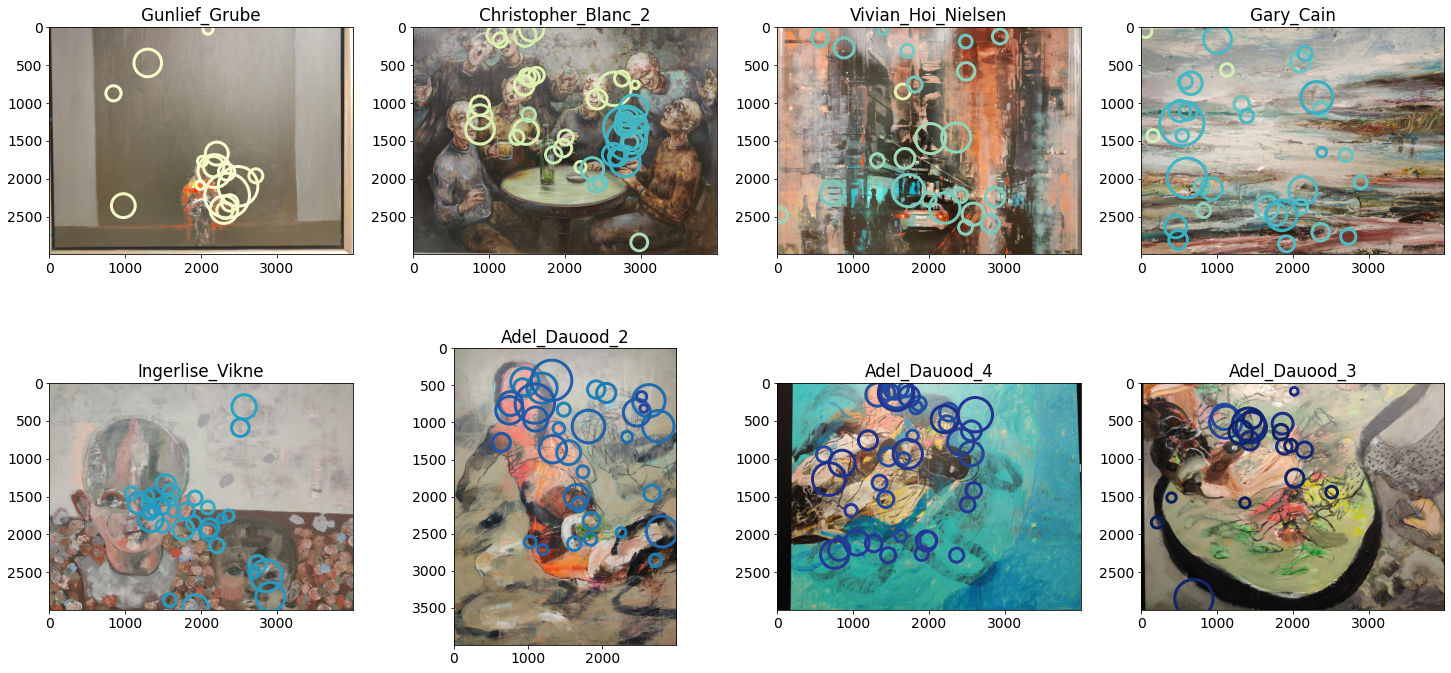

In [26]:
from matplotlib import cm

# take one example recording for the visualization
example_recording = recordings[0]
example_fixations = fixations[fixations['recording id'] == example_recording]

# select a color map and a normalization factor
cmap = cm.get_cmap('YlGnBu')
max_dur = max(example_fixations['aligned start timestamp [ns]'])

# sort the reference image by first fixation
first_fixation = example_fixations.groupby('AOI').describe()['aligned start timestamp [ns]']['min']
sorted_image_names = first_fixation.sort_values().index.values
sorted_image_path = [f'./reference_image_enrichments/Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_{x}_walking_csv/reference_image.jpeg' for x in sorted_image_names]

# plot the reference images in order
fig_visual_journey, ax_visual_journey = plt.subplots(int(np.ceil(len(sorted_image_names)/4)),4, figsize = (25,12))
for ax, im in zip(ax_visual_journey.flatten(), sorted_image_path):
    reference_image = Image.open(im)
    ax.imshow(np.asarray(reference_image))
    name = extract_name(im)
    aoi_names.append(name)
    ax.set_title(name)


# plot fixations on top of the reference images
for ax, aoi in zip(ax_visual_journey.flatten(), sorted_image_names):
    aoi_fixations = example_fixations[example_fixations['AOI'] == aoi]
    colors = [cmap(x/max_dur) for x in aoi_fixations['aligned start timestamp [ns]']]
    
    ax.scatter(aoi_fixations['fixation x [px]'],
               aoi_fixations['fixation y [px]'],
               edgecolors = colors, 
               facecolors = 'none',
               linewidth = 3, 
               s = aoi_fixations['duration [ms]']);   
    
# plot lines cluster-wise

## Metrics
To better describe and compare the fixations on the reference images, we will compute some fixation metrics. 

The metrics here are computed in the same way as the metrics on AOIs with in a reference image, I am not sure if we want to repeat them in this how-to.